#  Minimum Spanning Tree Problem 

## Gurobi Lazy cuts callback


In [1]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
#import pygraphviz as pygv
import os
from IPython.display import SVG, display


In [ ]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(undirected='true', strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos, width=0.1, fontsize=9)
    
    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    

def DrawSol (x):
    for i,j in G.edges():
        lab = x[i,j].x
        G[i][j]['capacity'] = x[i,j].x
        if x[i,j].x > 0.00001:
            if x[i,j].x > 0.999999:
                DrawG.add_edge(i, j, color='black', label=lab, fontsize=9)
            else:
                DrawG.add_edge(i, j, color='red', label=lab)
    path=str(basename)+'_sol.svg'
    DrawG.draw (path=path, format='svg')
    DrawG.delete_edges_from(DrawG.edges())
    

In [2]:
class args:
    filename = None
    scale = 40

### Decision variables:

$$
x_{ij} = \begin{cases} 1 \text{ if edge } e=\{i,j\} \text{ is selected} \\
0 \text{ otherwise.}\end{cases}
$$

### Formulation

$$
\min \sum_{e=\{i,j\} \in E} c_{ij} x_{ij} \\
\sum_{e=\{i,j\} \in E} x_{ij} = |V| - 1 \\
\sum_{e=\{i,j\} \in E(S)} x_{ij} \le |S| - 1, \;\; \forall S \subset V, 2 < |S| \le |V| - 1  \\
x \le 1 \\ 
x \ge 0
$$

## Gurobi callbacks

From the [Gurobi manual](http://www.gurobi.com/documentation/7.0/refman/py_callbacks.html):
    
> ### Callbacks
>Gurobi callback class. A callback is a **user function** that is called periodically by the Gurobi optimizer in order to **allow the user to query or modify the state of the optimization**. More precisely, if you pass a function that takes two arguments (``model`` and ``where``) as the argument to ``Model.optimize``, your function will be called during the optimization. Your callback function can then call ``Model.cbGet`` to query the optimizer for details on the state of the optimization.

>**Monitoring and early termination** Gurobi callbacks can be used both to monitor the progress of the optimization and to modify the behavior of the Gurobi optimizer. A simple user callback function might call ``Model.cbGet`` to produce a custom display, or perhaps to terminate optimization early (using ``Model.terminate``). 

>** Cut addition and MIP start** More sophisticated MIP callbacks might use ``Model.cbGetNodeRel`` or ``Model.cbGetSolution`` to retrieve values from the solution to the current node, and then use ``Model.cbCut`` or ``Model.cbLazy`` to add a constraint to cut off that solution, or ``Model.cbSetSolution`` to import a heuristic solution built from that solution.

>The Gurobi callback class provides a set of constants that are used within the user callback function. The first set of constants in this class list the options for the ``where`` argument to the user callback function. The ``where`` argument indicates from where in the optimization process the user callback is being called. Options are listed in the [Callback Codes](http://www.gurobi.com/documentation/7.0/refman/callback_codes.html#sec:CallbackCodes) section of this document.

>The other set of constants in this class list the options for the ``what`` argument to ``Model.cbGet``. The what argument is used by the user callback to indicate what piece of status information it would like to retrieve. The full list of options can be found in the [Callback Codes](http://www.gurobi.com/documentation/7.0/refman/callback_codes.html#sec:CallbackCodes) section. As with the ``where`` argument, you refer to a ``what`` constant through ``GRB.Callback``. For example, the simplex objective value would be requested using ``GRB.Callback.SPX_OBJVAL``.

>If you would like to pass data to your callback function, you can do so through the Model object. For example, if your program includes the statement ``model._value = 1`` before the optimization begins, then your callback function can query the value of ``model._value``. Note that the name of the user data field **must** begin with an underscore.

>When solving a model using multiple threads, note that the user callback is only ever called from a single thread, so you don't need to worry about the thread-safety of your callback.

>You can look at ``callback.py`` in the examples directory for details of how to use Gurobi callbacks. 

In [3]:
args.filename = "graph50.gml"
args.scale = 40

basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 50 nodes and 1225 edges


In [4]:
mst = gb.Model()

# Decision Variables

x = mst.addVars(G.edges(),\
                obj=[G[u][v]['cost'] for u,v in G.edges()],\
                ub = 1.0,\
                vtype=gb.GRB.BINARY, name='x')

# Cardinality constraint

mst.addConstr(x.sum() == G.number_of_nodes() - 1, 'Cardinality')

mst.update()

mst.write('mst.lp')

In [5]:
mst.optimize()

Optimize a model with 1 rows, 1225 columns and 1225 nonzeros
Variable types: 0 continuous, 1225 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective 124095.00000
Presolve removed 0 rows and 836 columns
Presolve time: 0.16s
Presolved: 1 rows, 389 columns, 389 nonzeros
Variable types: 0 continuous, 389 integer (121 binary)

Root relaxation: objective 1.348800e+04, 1 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    13488.000000 13488.0000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.42 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 13488 124095 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.348800000000e+04,

In [12]:
print("Obj value: ", mst.objVal)

Obj value:  13488.0


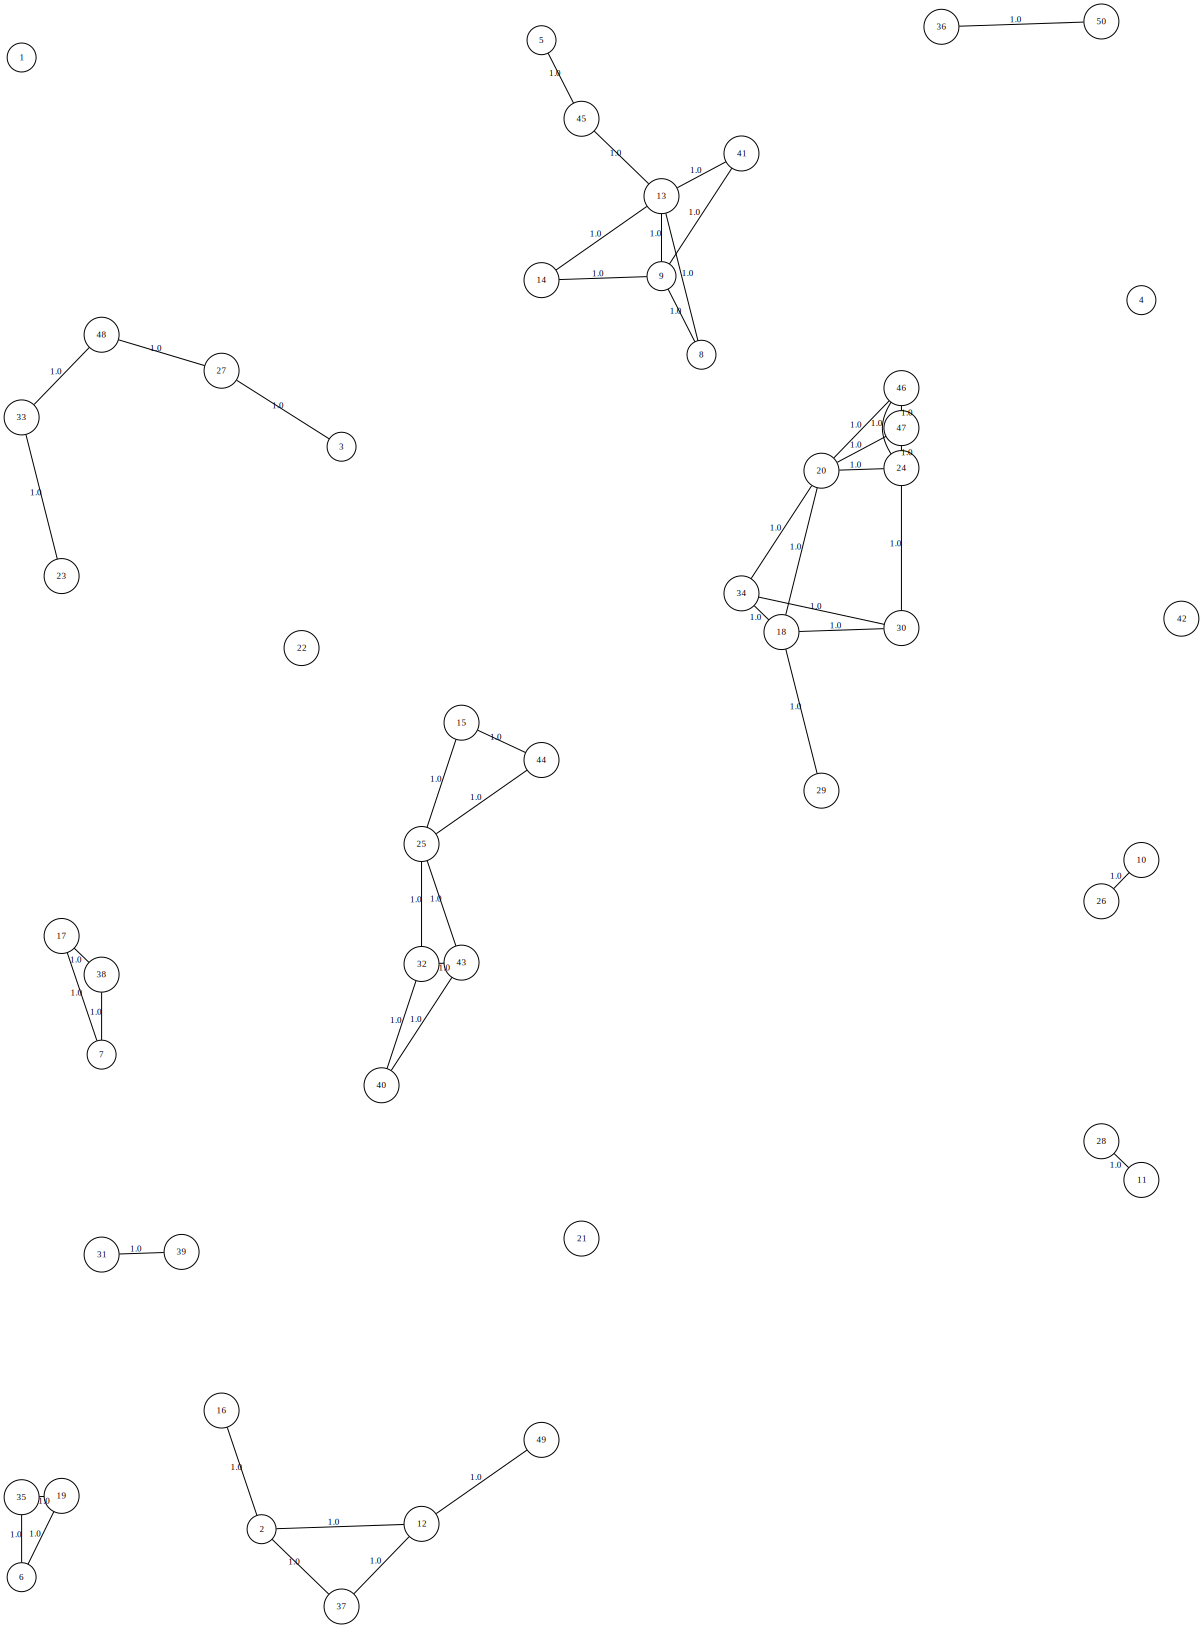

In [25]:
DrawInitialGraph()
DrawSol(x)
display(SVG(filename=basename+'_sol.svg'))

## Data needed to the callback

Our callback needs: 
   1. The graph $G$
   2. The variables $x$
   3. The separation routine
   4. The number of SECs generated so far
 
The above data are added to the ``mst`` Model. Note the ``_`` before the data name

In [13]:
mst._graph = G
mst._vars = x
mst._nSEC = 0



In [14]:
import math
import itertools

def SECcallback (model, where):

        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        xrel = model.cbGetSolution(x)
        G = model._graph
        
        #
        # Make a graph working copy
        # Not efficient !!!
        #
        
        solG = nx.Graph([(u,v) for (u,v) in G.edges() \
                         if math.isclose(xrel[u,v], 1.0, abs_tol=1E-3)])

        #
        # Check if solG is connected
        #
        
        for cc in nx.connected_components(solG):
            if G.subgraph(cc).number_of_edges() > len(cc) - 1 and len(cc) > 2:
                seclhs = gb.quicksum(x[u,v] if (u,v) in x else x[v,u] \
                                 for u,v in itertools.combinations(cc, 2))
            
                model.cbLazy(seclhs <= len(cc) - 1)
                

In [15]:
mst.reset()
mst.Params.lazyConstraints = 1
mst.optimize(SECcallback)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 1 rows, 1225 columns and 1225 nonzeros
Variable types: 0 continuous, 1225 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 5e+01]
Presolve time: 0.00s
Presolved: 1 rows, 1225 columns, 1225 nonzeros
Variable types: 0 continuous, 1225 integer (1225 binary)

Root relaxation: objective 1.348800e+04, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16831.000000 16831.0000  0.00%     -    2s

Cutting planes:
  Lazy constraints: 27

Explored 0 nodes (47 simplex iterations) in 2.12 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 16831 

Optimal solution found (tolerance 1.00e-04

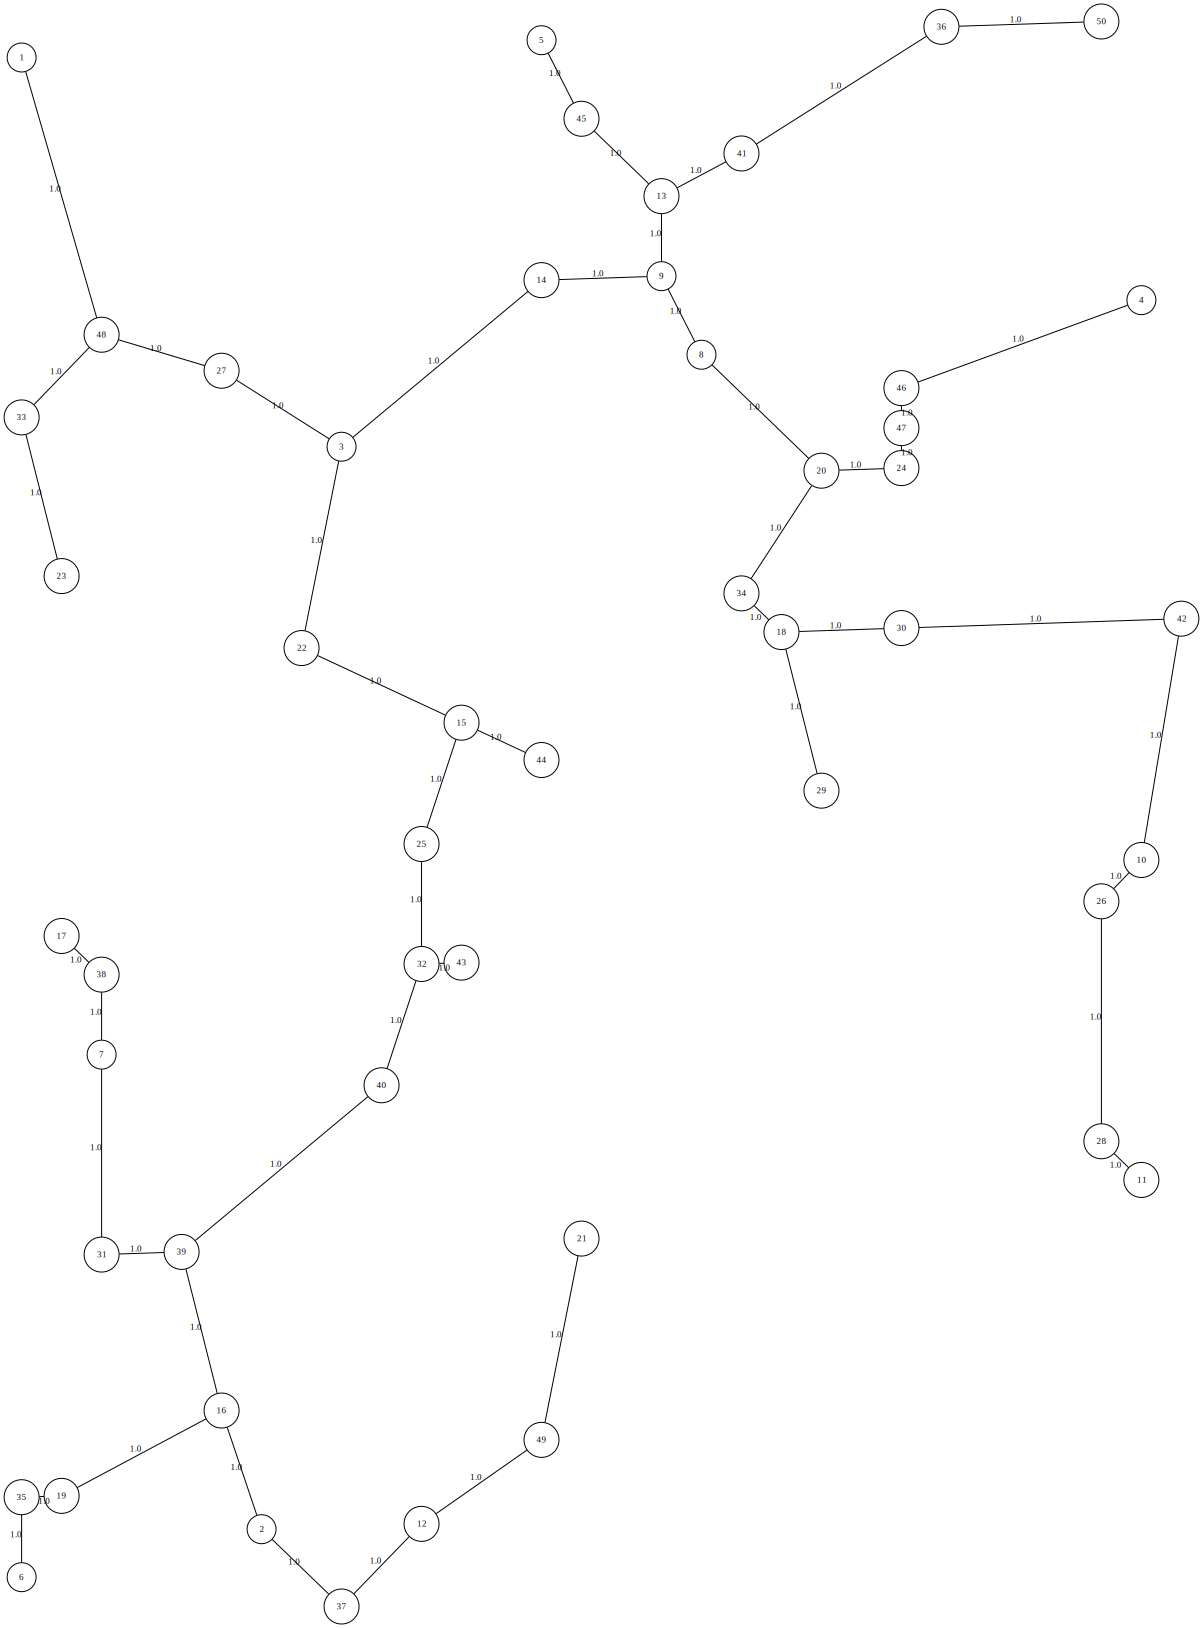

In [29]:
DrawInitialGraph()
DrawSol(x)
display(SVG(filename=basename+'_sol.svg'))